# Predicting Heart Disease Based On Physical Characteristics of Patients

# Introduction

Heart disease is an often-lethal condition, and being able to accurately predict if patients have it, based on easy-to-observe qualities, would allow for quicker action from doctors and better patient outcomes. So here we ask the question: is it possible to predict whether a patient has heart disease based on a set of measurable factors? To build a model that could answer this, we used the publicly-available heart disease dataset donated by the Hungarian Institute of Cardiology, the University Hospitals of Zurich and Basel, the V. A. Medical Center of Long Beach, and the Cleveland Clinic Foundation. Each row in this dataset represents a patient, and the columns store physical, health-related information about each patient — such as their age, sex, type of chest pain, and resting blood pressure. There are 14 variables in total. The column we are attempting to predict has values of either “true” or “false”, indicating whether a patient has some variety of heart disease. The dataset contains four databases, each with around 100 to 300 patients, donated by institutions in Switzerland, Hungary, and two locations in America. We trained and tested our model on data from all of the databases, as this gives us a larger sample size, and an additional variable to work with (region). This brings the total number of columns in our dataset to 15.

## Preliminary Exploratory Data Analysis

Captivating description of why we import needed modules

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set_seed(1048596)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in set_seed(1048596): could not find function "set_seed"


!EA Explanation of function and column_names variable

In [2]:
# Function to tidy up each of the separate datasets
# Discovery: in the non-cleveland sets, many of the more obscure columns have missing values in some rows. If you filter out all the rows that don't have missing values anywhere you sometimes end up with none from that set.
# TODO: get domain knowledge, use to find best predictors to use

tidy_heart_data <- function(df, region="") {
    colnames(df) <- column_names
    df <- mutate(df, region=region) #cleveland
    df$num<-ifelse(df$num==0,"true","false")
    if (region != "") {
        df <- mutate(df, region=as.factor(region))
        }
    return (df |> select(num,
                         region,
                         cp,
                         sex,
                         thalach,
                         trestbps,
                         chol,
                         fbs,
                         restecg) |> 
                          filter(cp!="?",
                                 sex!="?",
                                 thalach!="?",
                                 trestbps!="?",
                                 trestbps!="0",
                                 chol!="?",
                                 fbs!="?",
                                 restecg!="?")|>
                                 # exang!="?",
                                 # oldpeak!="?",
                                 # slope!="?",
                                 # ca!="?",
                                 # thal!="?"
                        
                          mutate(region=as.factor(region),
                                 sex=as.numeric(sex),
                                 cp=as.numeric(cp),
                                 thalach=as.numeric(thalach),
                                 trestbps=as.numeric(trestbps),
                                 chol=as.numeric(chol),
                                 fbs=as.numeric(fbs),
                                 restecg=as.numeric(restecg),
                                 # exang=as.numeric(exang),
                                 # oldpeak=as.numeric(oldpeak),
                                 # slope=as.numeric(slope),
                                 # ca=as.numeric(ca),
                                 # thal=as.numeric(thal),
                                 num = as.factor(num)))
    }

column_names <-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")

explanation of how all the cells below tidy the data (in separate code cells so each table is clearly associated with its relevant code

In [3]:
cleveland_data<- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                         col_name = FALSE)
cleveland_data <- tidy_heart_data(cleveland_data,"C")

cleveland_data               
# Table 1

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


num,region,cp,sex,thalach,trestbps,chol,fbs,restecg
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,C,1,1,150,145,233,1,2
false,C,4,1,108,160,286,0,2
false,C,4,1,129,120,229,0,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,C,4,1,115,130,131,0,0
false,C,2,0,174,130,236,0,2
true,C,3,1,173,138,175,0,0


In [4]:
hungarian_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
                          col_name = FALSE)
hungarian_data <- tidy_heart_data(hungarian_data,"H")
hungarian_data
# Table 2

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


num,region,cp,sex,thalach,trestbps,chol,fbs,restecg
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,H,2,1,185,130,132,0,2
true,H,2,1,160,120,243,0,0
true,H,1,0,170,170,237,0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,H,4,1,150,155,342,1,0
false,H,2,0,110,180,393,0,0
false,H,4,1,115,130,275,0,1


In [5]:

switzerland_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
                            col_name = FALSE)
switzerland_data <- tidy_heart_data(switzerland_data,"S")
switzerland_data
# Table 3

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


num,region,cp,sex,thalach,trestbps,chol,fbs,restecg
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,S,4,0,156,110,0,0,0
false,S,3,1,128,115,0,0,0
false,S,4,1,99,145,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,S,4,1,92,115,0,0,1
false,S,4,1,157,140,0,1,0
false,S,3,0,121,160,0,0,1


In [6]:
va_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
                   col_name = FALSE)
va_data <- tidy_heart_data(va_data,"VA")
va_data
# Table 4

Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X7, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


num,region,cp,sex,thalach,trestbps,chol,fbs,restecg
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,VA,4,1,112,140,260,0,1
true,VA,4,1,127,130,209,0,1
false,VA,4,1,140,132,218,0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,VA,4,0,154,127,333,1,1
false,VA,4,1,100,122,223,1,1
false,VA,2,1,93,120,254,0,2


!EA Why we are combining the data

In [7]:


all_data <-rbind(cleveland_data,hungarian_data,switzerland_data,va_data)

all_data
# Table 5

num,region,cp,sex,thalach,trestbps,chol,fbs,restecg
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,C,1,1,150,145,233,1,2
false,C,4,1,108,160,286,0,2
false,C,4,1,129,120,229,0,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,VA,4,0,154,127,333,1,1
false,VA,4,1,100,122,223,1,1
false,VA,2,1,93,120,254,0,2


!EA description of visualization

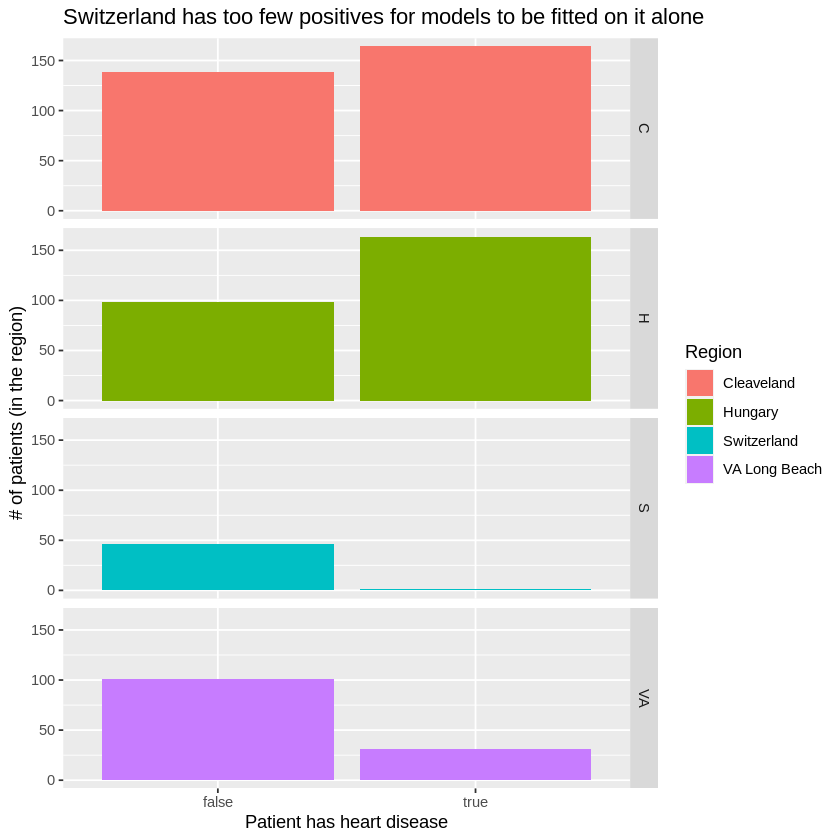

In [8]:
## TODO !EA Visualization of data relevant to the analysis (blocked on domain knowledge, need to know what variables to graph)
# Visualization of heart disease by region (will at least explain why we don't use f***ing Switzerland) 
# Of note for the description: switzerland sucks, Cleveland and Hungary (after being filtered for NA), have more people with heart disease than not.

# Figure 1
ggplot(all_data, aes(x = num, fill = region)) +
    geom_bar() +
    facet_grid(rows = vars(region)) +
    labs(x = "Patient has heart disease", y = "# of patients (in the region)", fill = "Region", title = "Switzerland has too few positives for models to be fitted on it alone") +
    scale_fill_discrete(labels = c("Cleaveland", "Hungary", "Switzerland", "VA Long Beach"))


Description of why we split

In [9]:
#split all the datasets into training and testing sets

cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

hungarian_split <- initial_split(hungarian_data, prop = 0.75, strata = num)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

switzerland_split <- initial_split(switzerland_data, prop = 0.75, strata = num)
switzerland_train <- training(switzerland_split)
switzerland_test <- testing(switzerland_split)

va_split <- initial_split(va_data, prop = 0.75, strata = num)
va_train <- training(va_split)
va_test <- testing(va_split)

all_split <- initial_split(all_data, prop = 0.75, strata = num)
all_train <- training(all_split)
all_test <- testing(all_split)

all_train # Table 6

num,region,cp,sex,thalach,trestbps,chol,fbs,restecg
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,C,4,1,129,120,229,0,2
false,C,4,1,147,130,254,0,2
false,C,4,1,155,140,203,1,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
true,VA,4,1,110,100,213,0,1
true,VA,4,1,96,130,207,0,1
true,VA,4,0,96,114,258,1,2


Description of the function find_predictors and how it will be used

In [10]:
find_predictors <- function(df) {
#!EA rename
    cancer_subset <- df
    names <- colnames(cancer_subset |> select(-num,-region))
    
    cancer_subset


    # create an empty tibble to store the results
    accuracies <- tibble(size = integer(), 
                         model_string = character(), 
                         accuracy = numeric())

    # create a model specification
    knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                                 neighbors = tune()) |>
         set_engine("kknn") |>
         set_mode("classification")

    # create a 5-fold cross-validation object
    cancer_vfold <- vfold_cv(cancer_subset, v = 5, strata = num)

    # store the total number of predictors
    n_total <- length(names)

    # stores selected predictors
    selected <- c()

    # for every size from 1 to the total number of predictors
    for (i in 1:n_total) {
        # for every predictor still not added yet
        accs <- list()
        models <- list()
        for (j in 1:length(names)) {
            # create a model string for this combination of predictors
            preds_new <- c(selected, names[[j]])
            model_string <- paste("num", "~", paste(preds_new, collapse="+"))

            # create a recipe from the model string
            cancer_recipe <- recipe(as.formula(model_string), 
                                    data = cancer_subset) |>
                              step_scale(all_predictors()) |>
                              step_center(all_predictors())

            # tune the KNN classifier with these predictors, 
            # and collect the accuracy for the best K
            acc <- workflow() |>
              add_recipe(cancer_recipe) |>
              add_model(knn_spec) |>
              tune_grid(resamples = cancer_vfold, grid = 10) |>
              collect_metrics() |>
              filter(.metric == "accuracy") |>
              summarize(mx = max(mean))
            acc <- acc$mx |> unlist()

            # add this result to the dataframe
            accs[[j]] <- acc
            models[[j]] <- model_string
        }
        jstar <- which.max(unlist(accs))
        accuracies <- accuracies |> 
          add_row(size = i, 
                  model_string = models[[jstar]], 
                  accuracy = accs[[jstar]])
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
    }

    accuracies <- mutate(accuracies, percent_accuracy = accuracy*100)

    return(accuracies)

}
    




Brief description of the accuracy calculation !EA

In [11]:
all_accuracy <- find_predictors(all_train)
print(all_accuracy, n=10)

cleveland_accuracy <- find_predictors(cleveland_train)
print(cleveland_accuracy, n=10)

hungarian_accuracy <- find_predictors(hungarian_train)
print(hungarian_accuracy, n=10)

# switzerland_accuracy <- find_predictors(switzerland_train) # Note: this dataset is way too small, such that many validation sets will lack "true" values. Tune the filtering-out of NA values, or just don't test it.
# print(switzerland_accuracy, n=10)

va_accuracy <- find_predictors(va_train)
print(va_accuracy, n=10)

# A tibble: 7 × 4
   size model_string                                   accuracy percent_accuracy
  <int> <chr>                                             <dbl>            <dbl>
1     1 num ~ thalach                                     0.657             65.7
2     2 num ~ thalach+cp                                  0.747             74.7
3     3 num ~ thalach+cp+sex                              0.768             76.8
4     4 num ~ thalach+cp+sex+fbs                          0.770             77.0
5     5 num ~ thalach+cp+sex+fbs+trestbps                 0.772             77.2
6     6 num ~ thalach+cp+sex+fbs+trestbps+chol            0.772             77.2
7     7 num ~ thalach+cp+sex+fbs+trestbps+chol+restecg    0.767             76.7
# A tibble: 7 × 4
   size model_string                                   accuracy percent_accuracy
  <int> <chr>                                             <dbl>            <dbl>
1     1 num ~ thalach                                     0.647          

! Fold1: internal: No control observations were detected in `truth` with control level 'true'.

! Fold2: internal: No control observations were detected in `truth` with control level 'true'.

! Fold3: internal: No control observations were detected in `truth` with control level 'true'.

! Fold4: internal: No control observations were detected in `truth` with control level 'true'.

! Fold5: internal: No control observations were detected in `truth` with control level 'true'.

! Fold1: internal: No control observations were detected in `truth` with control level 'true'.

! Fold2: internal: No control observations were detected in `truth` with control level 'true'.

! Fold3: internal: No control observations were detected in `truth` with control level 'true'.

! Fold4: internal: No control observations were detected in `truth` with control level 'true'.

! Fold5: internal: No control observations were detected in `truth` with control level 'true'.

! Fold1: internal: No control observatio

# A tibble: 7 × 4
   size model_string                                   accuracy percent_accuracy
  <int> <chr>                                             <dbl>            <dbl>
1     1 num ~ cp                                              1              100
2     2 num ~ cp+sex                                          1              100
3     3 num ~ cp+sex+thalach                                  1              100
4     4 num ~ cp+sex+thalach+trestbps                         1              100
5     5 num ~ cp+sex+thalach+trestbps+chol                    1              100
6     6 num ~ cp+sex+thalach+trestbps+chol+fbs                1              100
7     7 num ~ cp+sex+thalach+trestbps+chol+fbs+restecg        1              100
# A tibble: 7 × 4
   size model_string                                   accuracy percent_accuracy
  <int> <chr>                                             <dbl>            <dbl>
1     1 num ~ cp                                          0.766          

Description of the function !EA

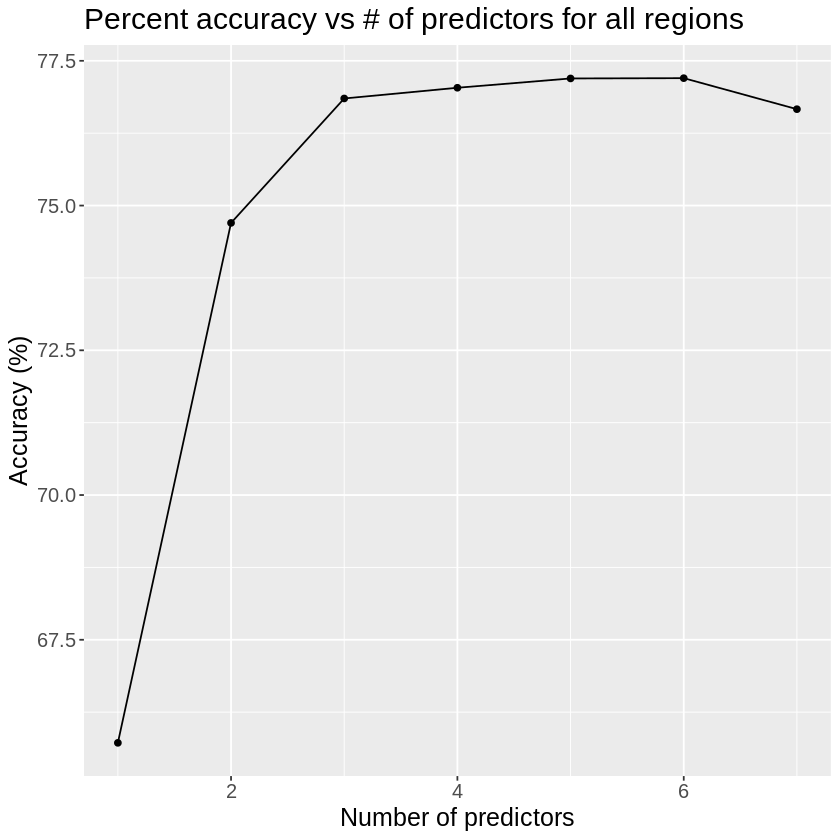

In [12]:
plot_accuracy <- function(accur, t="UNDEFINED"){
    ggplot(accur, aes(x = size, y = percent_accuracy)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of predictors", y = "Accuracy (%)", title = paste("Percent accuracy vs # of predictors for",t)) +
        theme(text = element_text(size = 15))
    }

plot_accuracy(all_accuracy, "all regions")

Each of the markdown cells here will describe the plot below it.

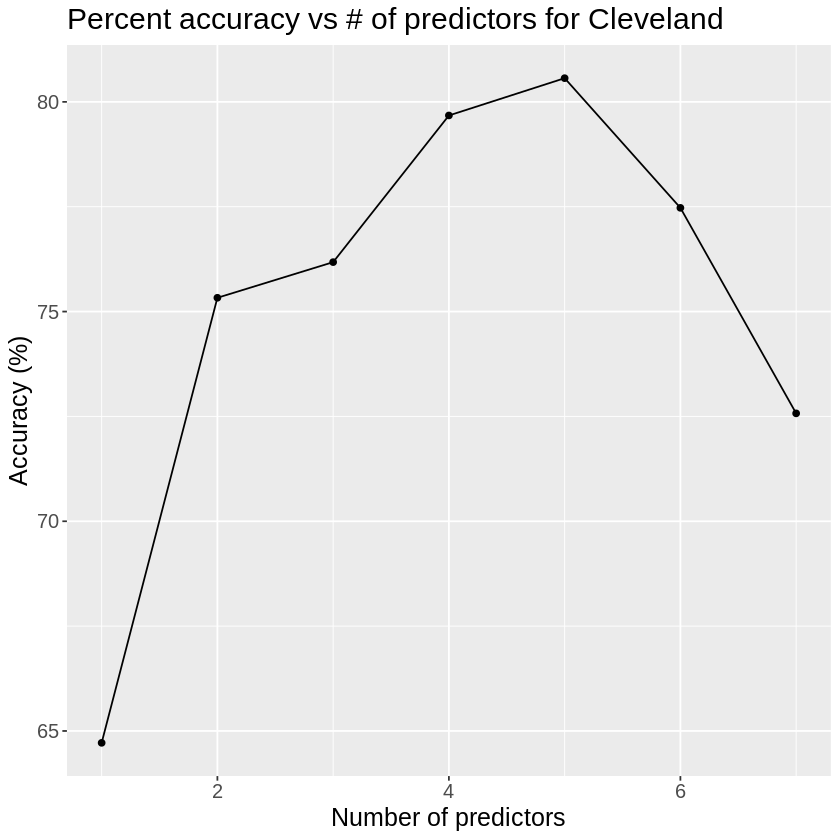

In [13]:
plot_accuracy(cleveland_accuracy, "Cleveland")

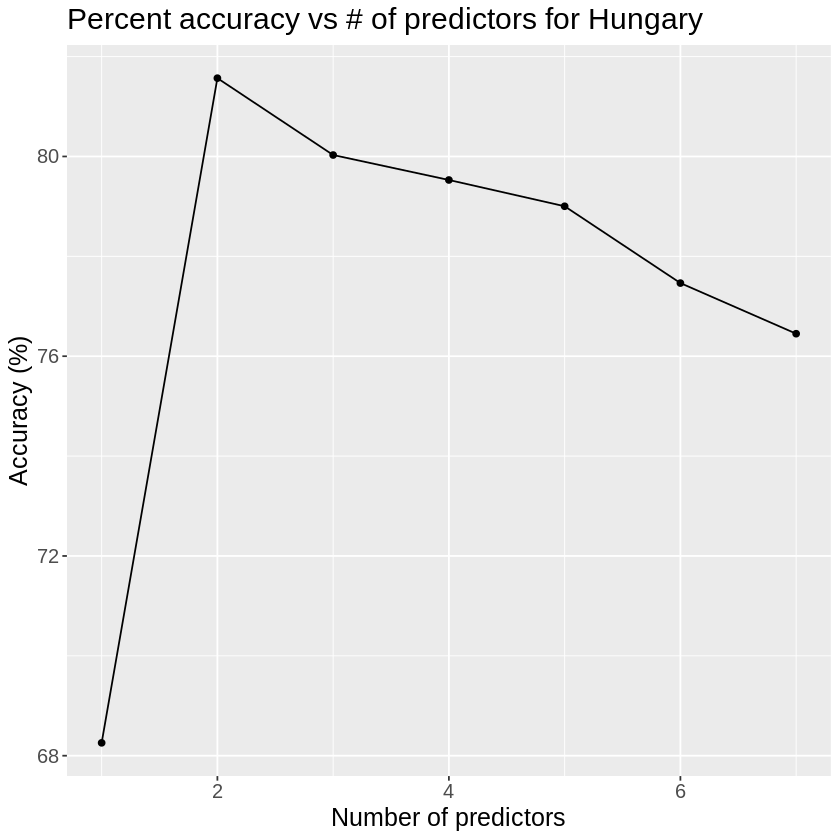

In [14]:
plot_accuracy(hungarian_accuracy, "Hungary")

In [15]:
# plot_accuracy(switzerland_accuracy, "Switzerland") # SCREW SWITZERLAND

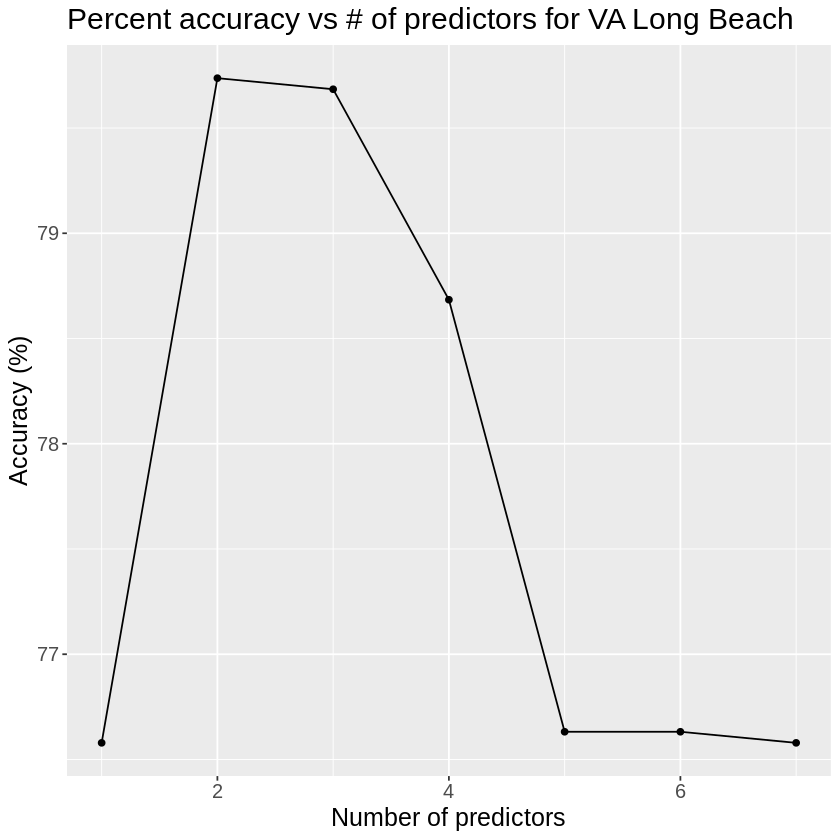

In [16]:
plot_accuracy(va_accuracy, "VA Long Beach")

!EA Mention how the code automatically picks the highest accuracy, as opposed to arbitrarily judging the location of an "elbow"

In [18]:
model_and_fit <- function(accuracy_df, train_df, test_df, region=""){
    # get predictors with max accuracy
    best_predictors <- accuracy_df |> slice_max(percent_accuracy, n = 1) |> pull(model_string)
    
    df_recipe <- recipe(as.formula(best_predictors), data = train_df) |> 
        step_scale(all_predictors()) |> 
        step_center(all_predictors())
    
    df_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> set_engine("kknn") |> set_mode("classification")
    
    df_fold <- vfold_cv(train_df, v = 10, strata = num)
    
    df_k_fit <- workflow() |>
        add_recipe(df_recipe) |>
        add_model(df_spec_tune) |>
        tune_grid(resamples = df_fold, grid = 10) |>
        collect_metrics()
    
    best_k <- df_k_fit |> slice_max(mean, n = 1) |> select(neighbors) |> pull()
    print(paste("The best value of K for", region, "is", best_k))
    
    df_spec_k <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |> set_engine("kknn") |> set_mode("classification")
    
    df_fit <- workflow() |>
        add_recipe(df_recipe) |>
        add_model(df_spec_k) |>
        fit(data = train_df)

    df_summary <- df_fit |>
        predict(test_df) |>
        bind_cols(test_df) |>
        metrics(truth = num, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        rename(accuracy = .estimate)
    return(c(df_summary,best_k)) # return the tuple so that I can access best_k in code later
    }
        
# cleveland_test




# model_and_fit(switzerland_accuracy,switzerland_train,switzerland_test, "Switzerland")[1] # Switzerland explodes for some reason, probably due to lack of data causing unexpected inputs.




[1] "The best value of K for all regions combined is 15"


accuracy
<dbl>
0.7956989


[1] "The best value of K for Cleveland is 11"


accuracy
<dbl>
0.7105263


[1] "The best value of K for Hungary is 14"


accuracy
<dbl>
0.8030303


[1] "The best value of K for VA Long Beach is 7"


accuracy
<dbl>
0.7941176


description for all the tables and the general interpretation of them !EA

In [ ]:
all_mod <- model_and_fit(all_accuracy,all_train,all_test, "all regions combined")
all_mod[1]

In [ ]:
cl_mod <- model_and_fit(cleveland_accuracy,cleveland_train,cleveland_test, "Cleveland")
cl_mod[1]

In [ ]:
hu_mod <- model_and_fit(hungarian_accuracy,hungarian_train,hungarian_test, "Hungary")
hu_mod[1]

In [ ]:
va_mod <- model_and_fit(va_accuracy,va_train,va_test, "VA Long Beach")
va_mod[1]

visualization of the analysis part 1

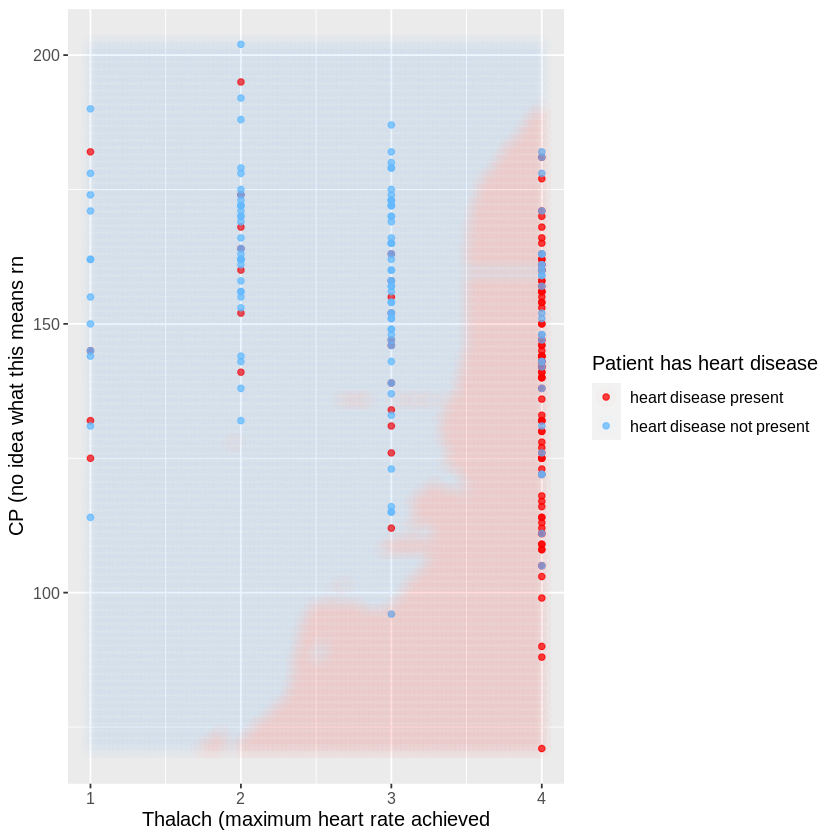

In [27]:
# Part 1: Best K for 2 predictors
# (Since we're unable to visualize more than 3 dimensions, we must pick only 2 predictors: I will select cp and thalach,
# which together had pretty decent accuracy results for most of the regions)

cleveland_recipe <- recipe(num ~ cp + thalach, data = cleveland_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors())
 
cl_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> set_engine("kknn") |> set_mode("classification")

cl_fold <- vfold_cv(cleveland_train, v = 10, strata = num)

cl_k_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(cl_spec_tune) |>
    tune_grid(resamples = cl_fold, grid = 10) |>
    collect_metrics()

cl_best_k <- cl_k_fit |> slice_max(mean, n = 1) |> select(neighbors) |> pull()



# Interesting idea: plot the number of datapoints in a region vs the best value of K. This can be accomplished by counting the rows of each dataframe and binding these summarized tibbles.
# Make the model_and_fit function return a tuple with the accuracy value and the best value of K so that I can pull those and bind them. Or just read the values off the output.
# ggplot(

In [ ]:
# Part 2: Fit
# We're viewing cleveland because it's the most accurate. (we've also then validated the choice of past ML researchers, who used the cleveland set exclusively as well)

cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = cl_best_k) |> #Maybe get the neighbors progrmatically?
    set_engine("kknn") |>
    set_mode("classification")

cleveland_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(cleveland_spec) |>
    fit(data = cleveland_train)


In [ ]:
# Part 3: Predict
# Inspired by the textbook, posted at https://canvas.ubc.ca/courses/102025/modules/items/4720443
# Note: since we can only graph two predictors, I'm picking the two that, combined, produced decent accuracy in all examples: thalach and CP
thal_grid <- seq(min(cleveland_train$thalach),
                 max(cleveland_train$thalach),
                 length.out = 100) # sets the desired length of the sequence
cp_grid <- seq(min(cleveland_train$cp),
                 max(cleveland_train$cp),
                 length.out = 100) # sets the desired length of the sequence
combined_grid <- as_tibble(expand.grid(thalach = thal_grid, cp = cp_grid)) # TODO !EA: figure out using the docs what CP is, put its name here

predicted_grid <- predict(cleveland_fit, combined_grid)

prediction_table <- bind_cols(predicted_grid,combined_grid) |> rename(num = .pred_class)


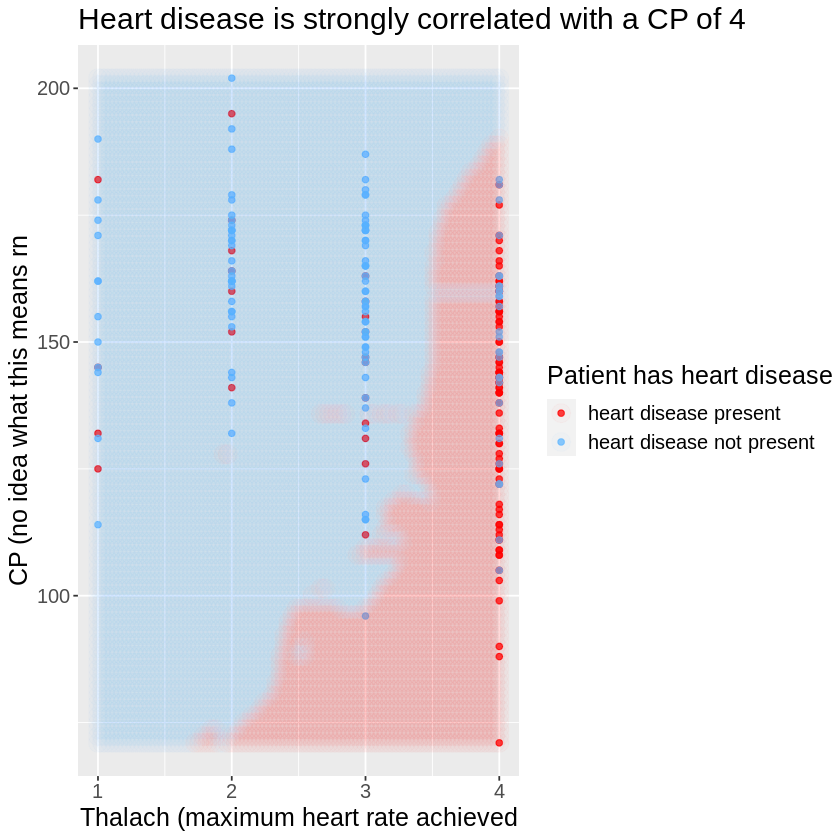

In [31]:
# Part 4: Graph
ggplot() +
    geom_point(data = cleveland_train,
               mapping = aes(x = cp, y = thalach, color = num), alpha = 0.75) +
    geom_point(data = prediction_table,
               mapping = aes(x = cp, y = thalach, color = num), alpha = 0.02, size = 5) +
    labs(color = "Patient has heart disease",
         x = "Thalach (maximum heart rate achieved)",
         y = "CP (no idea what this means rn",
         title ="Heart disease is strongly correlated with a CP of 4") +
    scale_color_manual(labels = c("heart disease present", "heart disease not present"),
                       values = c("red1", "steelblue1")) +
    theme(text = element_text(size = 15))
    
    



!EA | general idea: Here we can see why, perhaps, CP + thalact was so potent a combination. CP as a variable in particular is a strong indicator for heart disease, so any model including it will likely be benefitted.


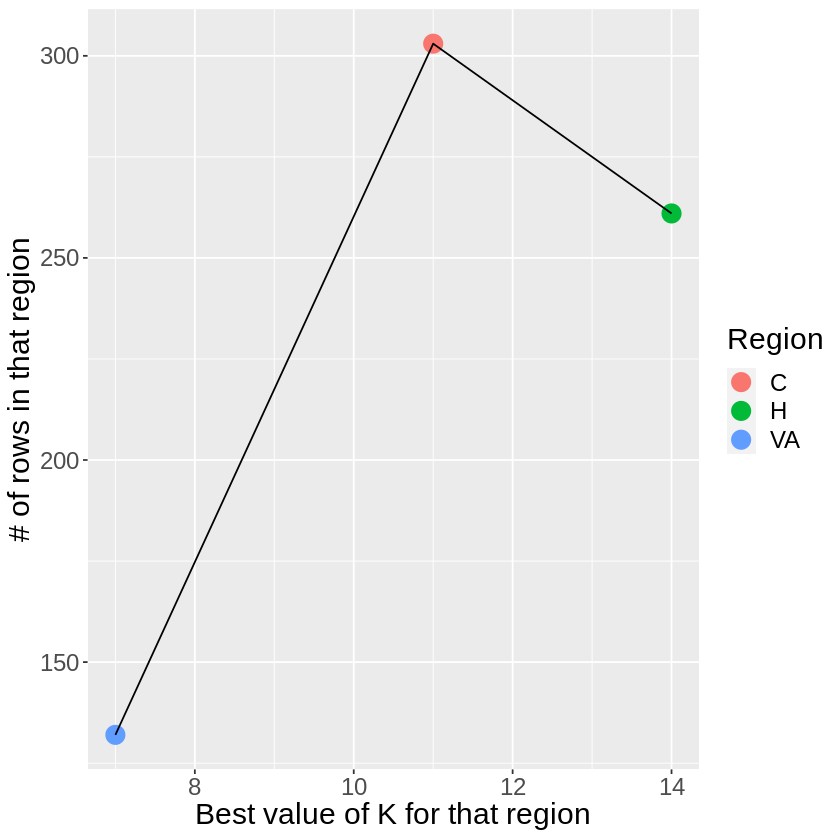

In [39]:
count_by_region <- group_by(all_data, region) |> summarize(count = n())
count_by_region <- filter(count_by_region, region != "S") # 'Cause Switzerland has innaccurate knn results due to low size
count_by_region <- bind_cols(count_by_region, tibble(best_k = c(cl_mod[2],hu_mod[2],va_mod[2])))
ggplot() +
    geom_point(data = count_by_region, 
               mapping = aes(x = best_k, y = count, color = region), size = 5) +
    geom_line(data = count_by_region, 
               mapping = aes(x = best_k, y = count)) +
    labs(x = "Best value of K for that region", y = "# of rows in that region", color = "Region") +
    theme(text = element_text(size = 18))

# With three datapoints it's hard to draw any clear conclusions. It makes sense that a dataset with very few datapoints would work best with a low value of K, though.
                             

## Methods

In order to decide what variables will be used as predictors for this model, we will employ forward selection, using the metric of accuracy. This will allow us to reliably determine, without assumptions, which variables contribute to improving the accuracy of the model and which do not. Because we have not yet done the analysis (and thus haven’t performed the forward selection yet) we cannot state which columns we will use at this time. To visualize the results, we will plot different choices of *k* for the model vs the accuracy that this choice of parameter produces. We will use this visualization to determine which choice of *k* results in the best accuracy.

## Expected Outcomes And Significance

### What do you expect to find?

With this data analysis, we would expect to find a correlation between whether or not an individual has a heart disease, and certain variables that we could use to predict it. For example, if an individual has a higher than average resting blood pressure, and higher than average cholesterol, we would expect for them to have a similarly higher chance of having a heart disease. This prediction is based on previous knowledge of heart diseases, but with our analysis we would expect to find some other factors that point to an individual having a higher or lower chance of contracting a heart disease. 

### What impact could such findings have?

These findings could allow hospitals to more accurately predict if an individual has a heart disease by attempting to classify it using our data set. It could also reduce the workload of doctors and nurses by automatically calculating how likely it is for someone to have a heart disease, which could get rid of the easy diagnoses and let doctors take over for the more difficult ones. By capturing the most impactful properties that indicate heart disease, we can also attempt to figure out methods of treatment and prevention that directly influence these properties.

### What future questions could this lead to?

This could lead to further questions about medical diagnoses from data, and if they could ever have any real life applications in the medical field. For example, based on the properties of a mole, could we predict if it is harmful or not? On the other hand, we could also ask the question of how legitimate our model is, by using a completely different heart disease data set and comparing the accuracy. Finally, as we have access to heart disease data from a variety of locations, we could ask the question: do the characteristics of heart disease remain consistent in different regions of the world? If they do not, we could try to figure out how it is different and why.